In [199]:
library(tidyverse)
library(cowplot)
library(ggExtra)
library(ggbeeswarm)
library(ggrepel)

`%+replace%` <- ggplot2::`%+replace%`

theme_zietzm <- function(base_size = 11.5, base_family = "") {
    # Starts with theme_bw and then modify some parts
    # Theme options are documentated at http://docs.ggplot2.org/current/theme.html
    ggplot2::theme_classic(base_size = base_size, base_family = base_family) %+replace%
    ggplot2::theme(

        strip.background  = ggplot2::element_rect(fill = NA, colour = 'grey90', size = 0),
        strip.text = element_text(vjust = 1, size = 10),
        plot.margin       = ggplot2::margin(t=2, r=2, b=2, l=2, unit='pt'),
        legend.spacing     = grid::unit(0.1, 'cm'),
        legend.key        = ggplot2::element_blank(),
        panel.border=element_rect(fill = NA, color = 'black', size = 0.5), 
        axis.line=element_line(size=0),
    )
}

## Calibration curves

In [2]:
full_cal_bins <- read_csv('../../data/task1/calibration/hetionet_calibration_bins.csv')
sampled_cal_bins <- read_csv('../../data/task1/calibration/hetionet_calibration_bins_sampled.csv')

Parsed with column specification:
cols(
  expected_frac = col_double(),
  lower_ci = col_double(),
  upper_ci = col_double(),
  feature = col_character(),
  feature_value = col_double(),
  metaedge = col_character()
)
Parsed with column specification:
cols(
  expected_frac = col_double(),
  lower_ci = col_double(),
  upper_ci = col_double(),
  feature = col_character(),
  feature_value = col_double(),
  metaedge = col_character()
)


In [3]:
full_cal_bins <- full_cal_bins %>%
    mutate(feature = feature %>% recode_factor(scaled_degree = 'Scaled degree',
                                               analytic_prior = 'Approximate prior',
                                               xswap_prior = 'Edge prior'))

sampled_cal_bins <- sampled_cal_bins %>%
    mutate(feature = feature %>% recode_factor(scaled_degree = 'Scaled degree',
                                               analytic_prior = 'Approximate prior',
                                               xswap_prior = 'Edge prior'))

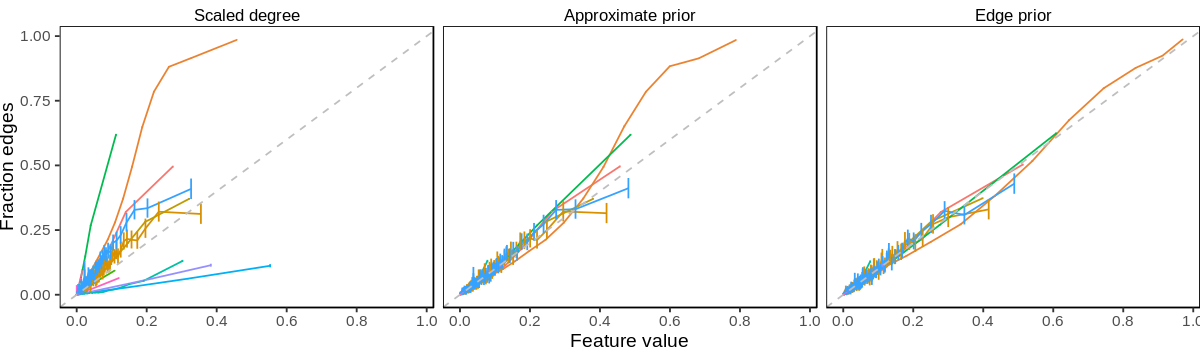

In [273]:
options(repr.plot.width=10, repr.plot.height=3)

full_calibration_plot <- (
    ggplot(full_cal_bins, aes(x = feature_value, y = expected_frac, ymin = lower_ci, 
                              ymax = upper_ci, color = metaedge))
    + geom_line()
    + geom_errorbar()
    + geom_abline(color = 'grey', linetype = 'dashed')
    + facet_wrap(vars(feature), nrow = 1)
    + theme_zietzm()
    + ylab('Fraction edges')
    + xlab('Feature value')
    + theme(legend.position = "none", plot.margin = unit(c(0.2, 0, 0.2, 0), "cm"))
    + scale_x_continuous(breaks = c(0, 0.2, 0.4, 0.6, 0.8, 1))
)

sampled_calibration_plot <- (
    ggplot(sampled_cal_bins, aes(x = feature_value, y = expected_frac, ymin = lower_ci, 
                              ymax = upper_ci, color = metaedge))
    + geom_line()
    + geom_errorbar()
    + geom_abline(color = 'grey', linetype = 'dashed')
    + facet_wrap(vars(feature),  nrow = 1)
    + theme_zietzm()
    + ylab('Fraction edges')
    + xlab('Feature value')
    + theme(legend.position = "none", plot.margin = unit(c(0.2, 0, 0.2, 0), "cm"))
)
    
full_calibration_plot

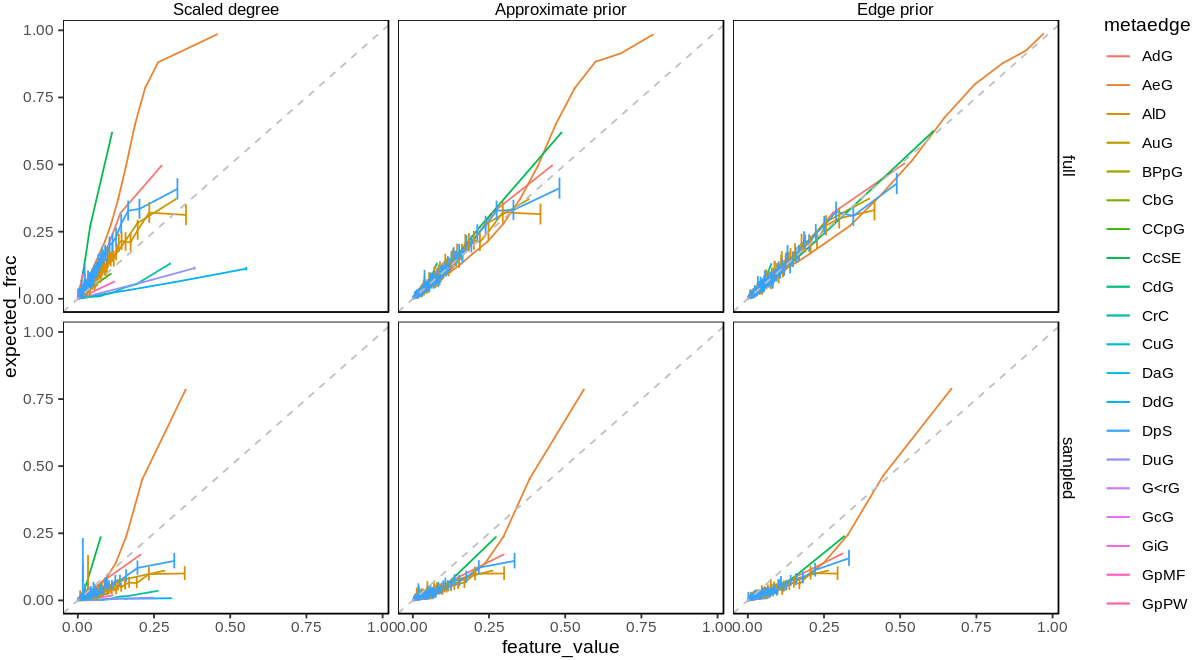

In [58]:
options(repr.plot.width=10, repr.plot.height=5.5)


calibration_plot <- bind_rows(
    full_cal_bins %>% mutate(network = 'full'),
    sampled_cal_bins %>% mutate(network = 'sampled')
) %>% 
# filter(metaedge == 'AeG') %>%
ggplot(aes(x = feature_value, y = expected_frac, ymin = lower_ci, 
                ymax = upper_ci, color = metaedge)) + 
geom_line() + 
geom_errorbar() + 
geom_abline(color = 'grey', linetype = 'dashed') + 
facet_grid(rows = vars(network), cols = vars(feature)) +
theme_zietzm()

calibration_plot

## Calibration metrics

In [59]:
metrics <- read_csv('../../data/task1/calibration/hetionet_calibration_metrics.csv') %>%
   mutate(
       network = network %>% recode_factor(full = 'Unsampled network', 
                                           sampled = 'Sampled network', 
                                           other = 'Separate network'),
       feature = feature %>% recode_factor(scaled_degree = 'scaled degree', 
                                           analytic_prior = 'approx',
                                           xswap_prior = 'edge prior'),
   )

metrics %>% head

Parsed with column specification:
cols(
  network = col_character(),
  metaedge = col_character(),
  feature = col_character(),
  cal = col_double(),
  ref = col_double(),
  brier = col_double(),
  weighted_mae = col_double(),
  auroc = col_double()
)


network,metaedge,feature,cal,ref,brier,weighted_mae,auroc
<fct>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Unsampled network,AdG,edge prior,0.0005348332,0.007573513,0.008108346,0.3356053,0.9893918
Unsampled network,AdG,approx,0.0006444262,0.007571256,0.008215682,0.3512889,0.9891555
Unsampled network,AdG,scaled degree,0.0015091243,0.007574097,0.009083222,0.4140236,0.9891437
Unsampled network,AeG,edge prior,0.0011463458,0.018729566,0.019875912,0.1737322,0.9873503
Unsampled network,AeG,approx,0.0045910898,0.018719604,0.023310694,0.2541119,0.9868655
Unsampled network,AeG,scaled degree,0.0195552381,0.018735534,0.038290772,0.3850257,0.9868530


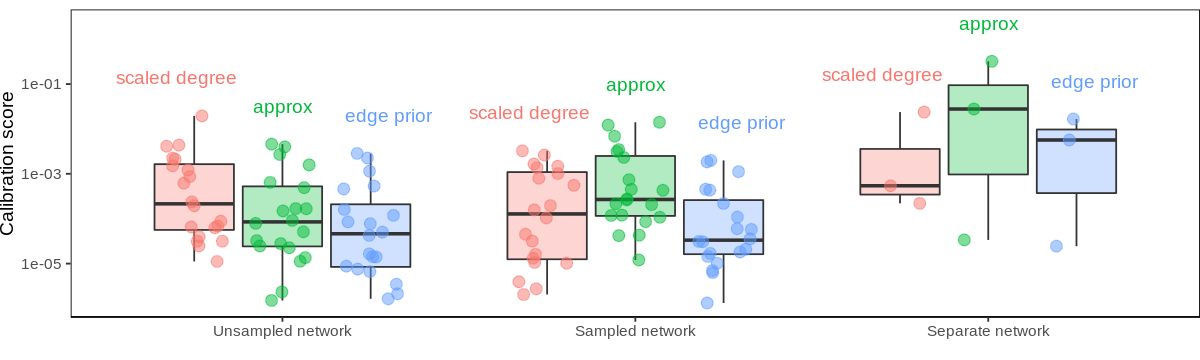

In [446]:
options(repr.plot.width=10, repr.plot.height=3)

labels_df <- metrics %>% 
    group_by(feature, network) %>% 
    top_n(cal, n = 1) %>%
    mutate(
#         y = 7e-2,
        y = 7 * cal
    )

cal_3 <- (
    ggplot(metrics, aes(x = network, y = cal))
    + geom_boxplot(aes(fill = feature), outlier.shape = NA, alpha = 0.3)
    + geom_point(aes(color = feature, group = feature), alpha = 0.5, cex = 3,
                 position = position_jitterdodge(jitter.width = 0.4))
    + theme_zietzm()
    + scale_y_log10()
    + theme(plot.margin = unit(c(0.2, 0, 0, 0), "cm"))
    + xlab("") 
    + ylab("Calibration score")
    + geom_text(data = labels_df, aes(x = network, y = y, color = feature, label = feature),
                position = position_dodge2(width = 0.9), size = 4)
    + theme(legend.position = 'none')
)

cal_3

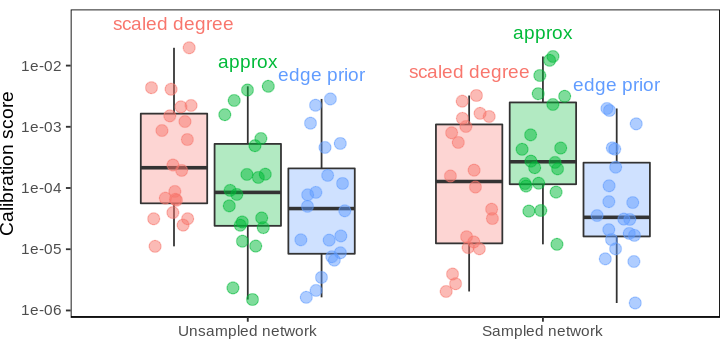

In [364]:
options(repr.plot.width=6, repr.plot.height=3)

labels_df <- metrics %>% 
    filter(network != 'Separate network') %>%
    group_by(feature, network) %>% 
    top_n(cal, n = 1) %>%
    mutate(y = 7e-2)

cal_2 <- (
    ggplot(metrics %>% filter(network != 'Separate network'), aes(x = network, y = cal))
    + geom_boxplot(aes(fill = feature), outlier.shape = NA, alpha = 0.3)
    + geom_point(aes(color = feature, group = feature), alpha = 0.5, cex = 3, 
                 position = position_jitterdodge(jitter.width = 0.4, seed = 0))
    + theme_zietzm()
    + scale_y_log10()
    + theme(plot.margin = unit(c(0.2, 0, 0, 0), "cm"), legend.position = 'none')
    + xlab("") 
    + ylab("Calibration score")
    + geom_text(data = labels_df, aes(x = network, y = 2.5 * cal, color = feature, label = feature),
                position = position_dodge2(width = 0.75), size = 4)
)

cal_2

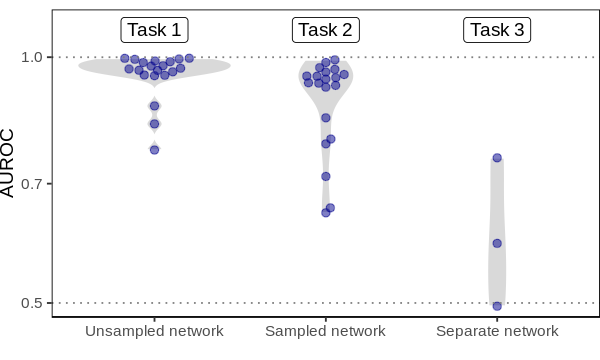

In [466]:
options(repr.plot.width=5, repr.plot.height=2.5)

labels_df <- metrics %>%
    filter(feature == 'edge prior') %>%
    group_by(network) %>% 
    top_n(auroc, n = 1) %>%
    mutate(
#         y = 1.1 * auroc,
        y = 1.08,
        label = network %>% recode_factor('Unsampled network' = 'Task 1',
                                          'Sampled network' = 'Task 2',
                                          'Separate network' = 'Task 3')
    )

auroc <- (
    ggplot(metrics %>% filter(feature == 'edge prior'), aes(x = network, y = auroc))
#     + geom_boxplot(aes(fill = feature), outlier.shape = NA, alpha = 0.3)
    + geom_violin(data = metrics %>% 
#                       filter(feature == 'edge prior' & network != 'Separate network'), 
                      filter(feature == 'edge prior'), 
                  fill = 'grey85', color = 'white')
    + scale_x_discrete(limits = c('Unsampled network', 'Sampled network', 'Separate network'))
    + geom_beeswarm(alpha = 0.5, cex = 2, color = 'darkblue', size = 2)
    + theme_zietzm()
    + scale_y_log10()
    + theme(plot.margin = unit(c(0.2, 0, 0, 0), "cm"), legend.position = 'none')
    + xlab("") 
    + ylab("AUROC")
    + geom_label(data = labels_df, aes(x = network, y = y, label = label),
                 position = position_dodge2(width = 0.75), size = 4)
    + coord_cartesian(ylim = c(0.5, 1.1))
    + geom_hline(yintercept = 0.5, color = 'grey50', linetype = 'dotted')
    + geom_hline(yintercept = 1, color = 'grey50', linetype = 'dotted')
)

ggsave(filename = '../../img/auroc.png', auroc, dpi = 300, width = 5, height = )

auroc

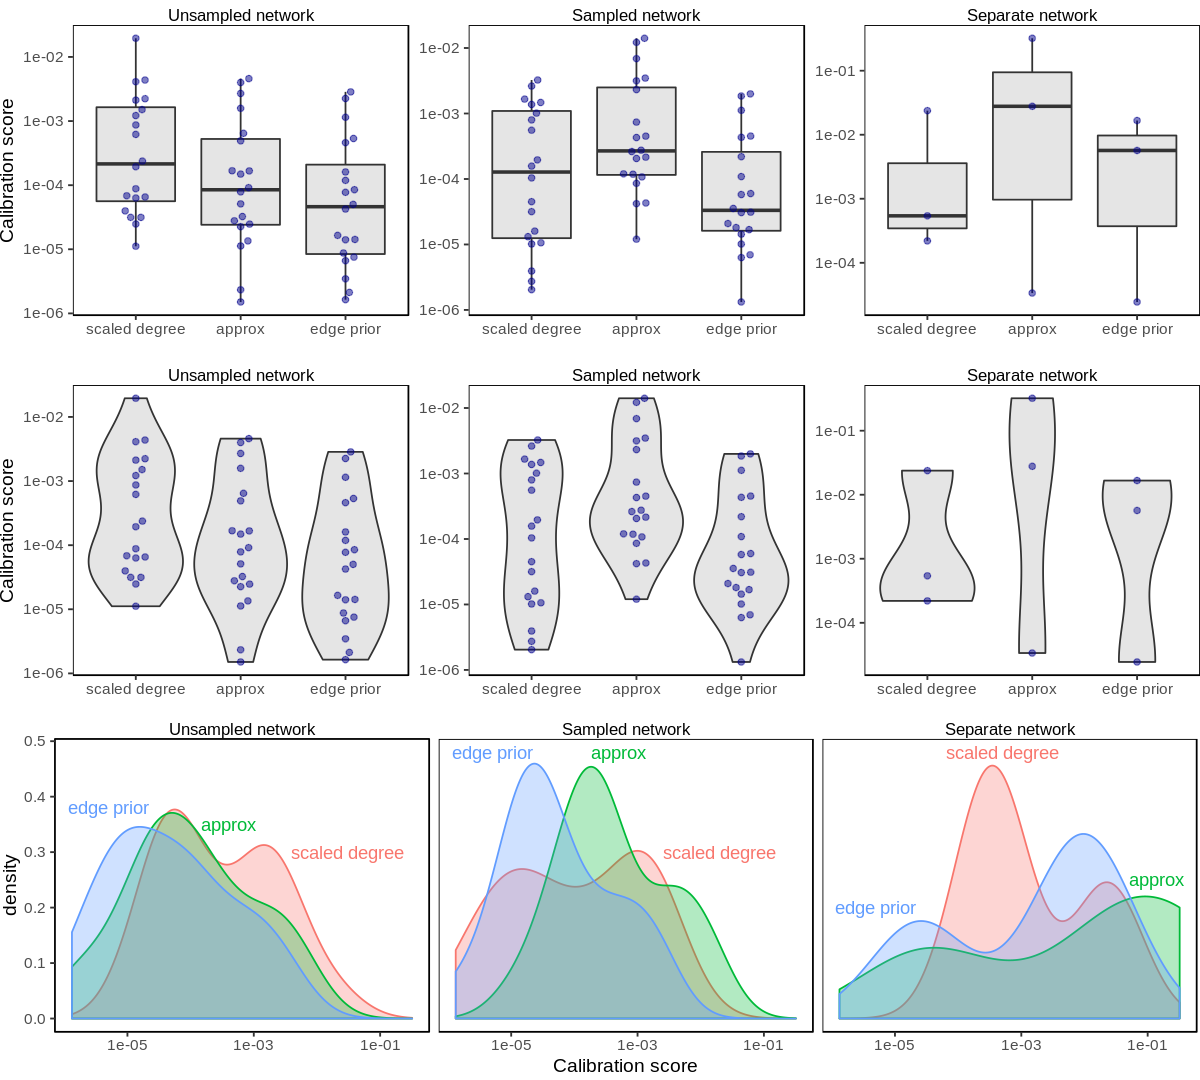

In [270]:
options(repr.plot.width=10, repr.plot.height=3)

cal_box <- (
    ggplot(metrics, aes(x = feature, y = cal))
    + facet_wrap(vars(network), scales = 'free_y')
    + geom_boxplot(outlier.shape = NA, fill = 'grey90')
    + geom_beeswarm(alpha = 0.5, color = 'darkblue', cex = 3)
    + theme_zietzm()
    + scale_y_log10()
    + theme(plot.margin = unit(c(0.2, 0, 0, 0), "cm"))
    + xlab("") 
    + ylab("Calibration score")
)

cal_violin <- (
    ggplot(metrics, aes(x = feature, y = cal))
    + facet_wrap(vars(network), scales = 'free_y')
#     + geom_boxplot(outlier.shape = NA, fill = 'grey90')
    + geom_violin(fill = 'grey90')
    + geom_beeswarm(alpha = 0.5, color = 'darkblue', cex = 3)
    + theme_zietzm()
    + scale_y_log10()
    + theme(plot.margin = unit(c(0.2, 0, 0, 0), "cm"))
    + xlab("") 
    + ylab("Calibration score")
)


labels_df <- data.frame(
    x = c(5e-6, 4e-4, 3e-2, 
          5e-6, 5e-4, 2e-2,
          5e-6, 1.4e-1, 5e-4),
    y = c(0.38, 0.35, 0.3,
          0.48, 0.48, 0.3,
          0.2, 0.25, 0.48),
    network = c('Unsampled network', 'Unsampled network', 'Unsampled network',
                'Sampled network', 'Sampled network', 'Sampled network',
                'Separate network', 'Separate network', 'Separate network'),
    feature = c('edge prior', 'approx', 'scaled degree', 
                'edge prior', 'approx', 'scaled degree',
                'edge prior', 'approx', 'scaled degree'),
    label = c('edge prior', 'approx', 'scaled degree', 
              'edge prior', 'approx', 'scaled degree',
              'edge prior', 'approx', 'scaled degree')
)

cal_density <- metrics %>%
ggplot(aes(x = cal, color = feature, fill = feature)) +
geom_density(alpha = 0.3, adjust = 1) +
facet_wrap(vars(network)) +
scale_x_log10() +
theme_zietzm() +
geom_text(data = labels_df, aes(x = x, y = y, label = label)) +
theme(legend.position = 'none') +
xlab('Calibration score')

options(repr.plot.width=10, repr.plot.height=9)
plot_grid(cal_box, cal_violin, cal_density, ncol = 1)

# options(repr.plot.width=10, repr.plot.height=3)
# cal_density

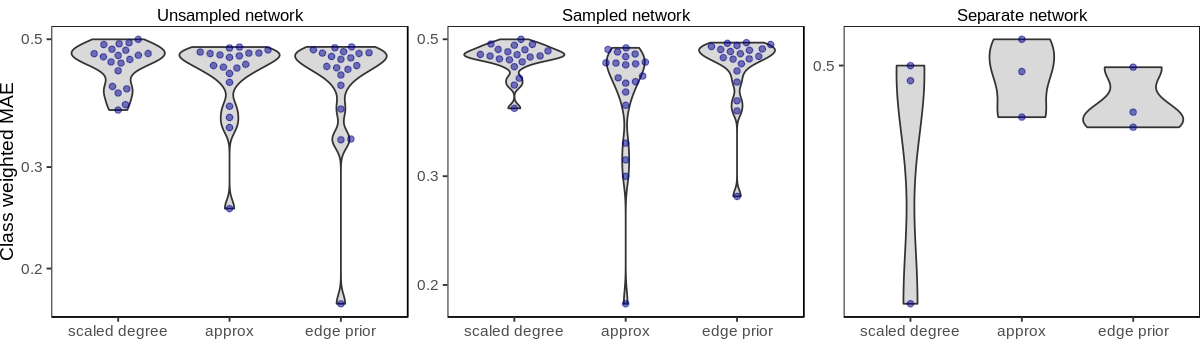

In [166]:
options(repr.plot.width=10, repr.plot.height=3)

wmae_violin <- (
    ggplot(metrics, aes(x = feature, y = weighted_mae))
    + facet_wrap(vars(network), scales = 'free_y')
#     + geom_boxplot(outlier.shape = NA)
    + geom_violin(fill = 'grey85')
    + geom_beeswarm(alpha = 0.5, color = 'darkblue', cex = 3)
    + theme_zietzm()
#     + scale_y_log10()
    + scale_y_continuous(trans = 'log10')
    + theme(plot.margin = unit(c(0.2, 0, 0, 0), "cm"))
    + xlab("") 
    + ylab("Class weighted MAE")
)

wmae_violin

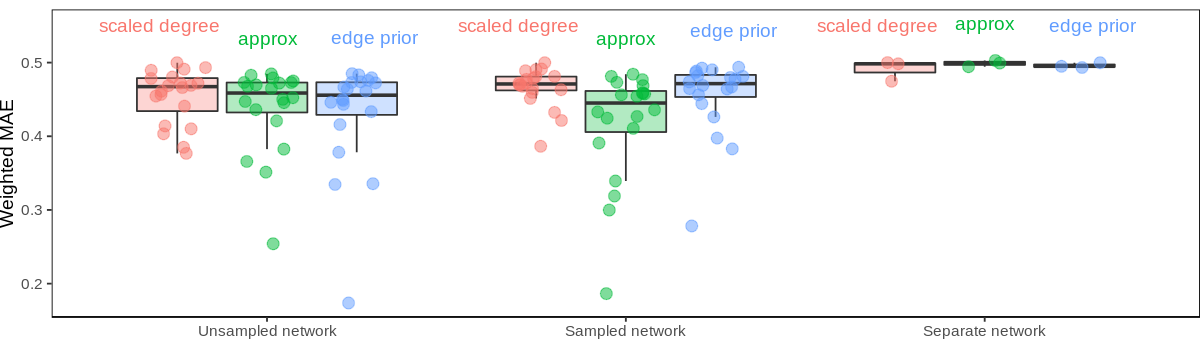

In [463]:
options(repr.plot.width=10, repr.plot.height=3)

labels_df <- metrics %>% 
    group_by(feature, network) %>% 
    top_n(weighted_mae, n = 1) %>%
    mutate(
#         y = 7e-2,
        y = 1.1 * weighted_mae
    )

cal_3 <- (
    ggplot(metrics, aes(x = network, y = weighted_mae))
    + geom_boxplot(aes(fill = feature), outlier.shape = NA, alpha = 0.3)
    + geom_point(aes(color = feature, group = feature), alpha = 0.5, cex = 3,
                 position = position_jitterdodge(jitter.width = 0.4))
    + theme_zietzm()
#     + scale_y_log10()
    + theme(plot.margin = unit(c(0.2, 0, 0, 0), "cm"))
    + xlab("") 
    + ylab("Weighted MAE")
    + geom_text(data = labels_df, aes(x = network, y = y, color = feature, label = feature),
                position = position_dodge2(width = 0.9), size = 4)
    + theme(legend.position = 'none')
)

cal_3

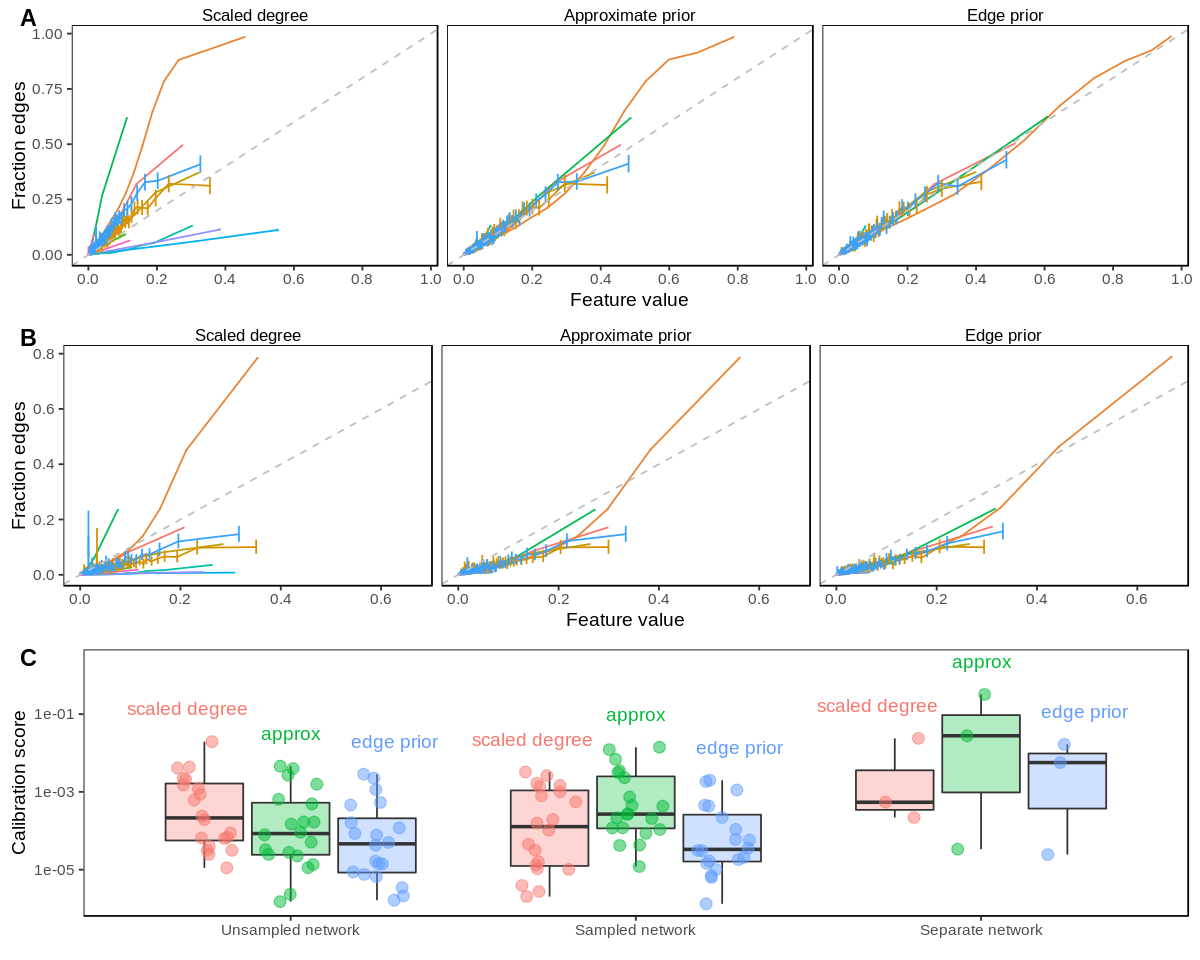

In [460]:
options(repr.plot.width=10, repr.plot.height=8)

calibration_figure <- plot_grid(
    full_calibration_plot, 
    sampled_calibration_plot, 
    cal_3, 
    ncol = 1, labels = c("A", "B", "C")) + 
    theme(plot.margin = unit(c(0, 0.25, 0, 0.25), 'cm'))


# ggsave(filename = '../../img/fig4.calibration.png', plot = calibration_figure, 
#        dpi = 300, width = 9, height = 8)
calibration_figure